In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn import svm
from sklearn import metrics
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats, linalg
import warnings
import math
import random
from sklearn.exceptions import ConvergenceWarning
def conv_r2z(r):
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
def conv_z2r(z):
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
os.chdir('/gpfs/milgram/project/chun/jk2992/rest_thoughts/') # change to your folder path

In [2]:
def reshape_FC(fc): # define a function to help read in FC data
    fc = np.transpose(fc,(2,0,1))
    fc = np.reshape(fc,(fc.shape[0],fc.shape[1]*fc.shape[2]))
    return fc

def get_num(string): # define a function to help read in behavioral data
    num = []
    for i in range(len(string)):
        if i % 5 == 2:
            num.append(int(string[i]))
    return num

# load FC
rest_FC = scipy.io.loadmat('./data/brain/rest_fc.mat')['rest'][0]
# delete 1032 s1r1 (response box error), index 29 because there is no 1004 and 1019
rest_FC[29] = np.delete(rest_FC[29],[0],axis = 0)
print('FC profiles shape: '+str(len(rest_FC))+'*'+str(rest_FC[2].shape))

# prepare FC for each subject
nsubj = len(rest_FC)
FC_bysub = []
for i in range(nsubj):
    FC_bysub.append(reshape_FC(rest_FC[i]))

def prepare_data(this_var): # define a function as a pipeline to prepare CAT data for training
    df = pd.read_csv('./data/beh/all_ratings.csv')
    beh_list = np.unique(df['Sub']) # create a behavioral participant list
    # print('We have '+str(len(beh_list)) + ' participants')
    # create a behavioral dataset by subject
    idx = -1
    beh_bysub = []
    for sub in range(len(beh_list)):
        sub_data = df[df['Sub']==beh_list[sub]][this_var]
        sub_vec = []
        # print(str(beh_list[sub]) + ': ' + str(len(sub_data)*8))
        for run in range(len(sub_data)):
            idx = idx + 1
            run_data = get_num(sub_data[idx])
            sub_vec.append(run_data)
        sub_vec = np.asarray(sub_vec)
        sub_vec = np.reshape(sub_vec,(sub_vec.shape[0]*sub_vec.shape[1]))
        # try zscore
        sub_vec = stats.zscore(sub_vec)
        beh_bysub.append(sub_vec)

    # remove 1032 s1r1, 1044 s1r2
    beh_bysub[29] = np.delete(beh_bysub[29],range(0,8))
    beh_bysub[41] = np.delete(beh_bysub[41],range(8,16))

    # let's double check the brain match behavior
    count = 0
    for i in range(nsubj):
        if len(beh_bysub[i]) == FC_bysub[i].shape[1]:
            count = count + 1
    # if count == nsubj:
    #     print('All behavioral and brain data match')

    good_trial_bysub = []
    good_trial_id_bysub = []
    good_sub = []
    for sub in range(nsubj):
        sub_data = FC_bysub[sub]
        count = 0 
        good_trial_id = []
        for trial in range(sub_data.shape[1]):
            # a good trial has < 1000 missing FC (3 missing nodes)
            if np.sum(np.isnan(sub_data[:,trial])) < 1000:
                count = count + 1
                good_trial_id.append(trial)
        
        good_trial_bysub.append(count)
        # a good participant has > 20 good trials
        if count > 20:
            good_sub.append(sub)
            good_trial_id = np.transpose(good_trial_id)
            good_trial_id_bysub.append(good_trial_id)
    good_sub = np.transpose(good_sub)

    # select good participants
    nsubj_good = len(good_sub)
    FC_selected, beh_selected = [], []
    for i in range(nsubj_good):
        tmp_FC = FC_bysub[good_sub[i]]
        tmp_FC = tmp_FC[:,good_trial_id_bysub[i]]
        FC_selected.append(tmp_FC)
        
        tmp_beh = beh_bysub[good_sub[i]]
        tmp_beh = tmp_beh[good_trial_id_bysub[i]]    
        beh_selected.append(tmp_beh)

    # let's double check the brain match behavior
    count = 0
    count_trial = []
    for i in range(nsubj_good):
        if len(beh_selected[i]) == FC_selected[i].shape[1]:
            count = count + 1
            count_trial.append(len(beh_selected[i]))
    # if count == nsubj_good:
    #     print('All behavioral and brain data match -- 2nd check')
    
    # reshape FC_selected
    training_FC = []
    training_beh = []
    for i in range(len(FC_selected)):
        for j in range(FC_selected[i].shape[1]):
            training_FC.append(FC_selected[i][:,j])
            training_beh.append(beh_selected[i][j])
    
    # one subject did not change the ratings for future and past.
    # Thus there are nan values in these two dimensions. Now removing these nans
    if this_var == 'Future' or this_var == 'Past':
        nanidx = np.where(np.isnan(training_beh))
        training_FC = np.delete(training_FC,nanidx,axis=0)
        training_beh = np.delete(training_beh,nanidx)
    
    training_FC = np.asarray(training_FC)
    training_beh = np.asarray(training_beh)

    return training_FC, training_beh

nR = 268
def load_edges(this_var): # define a function to read in the underlying network defined in step04_SVR_dimensions.ipynb
    # print('Loading FC features...')
    nR = 268
    filepath = './results/CPMs/'+this_var+'_features.mat'
    pos_feat = scipy.io.loadmat(filepath)['pos_feat']
    neg_feat = scipy.io.loadmat(filepath)['neg_feat']
    pos_feat, neg_feat = np.average(pos_feat,0), np.average(neg_feat,0)
    for i1 in range(nR):
        for i2 in range(nR):
            if pos_feat[i1,i2]<1:
                pos_feat[i1,i2]=0
            if neg_feat[i1,i2]<1:
                neg_feat[i1,i2]=0
    # print(' #pos = '+str(int(np.sum(pos_feat)/2)), ', #neg = '+str(int(np.sum(neg_feat)/2)))
    all_feat = pos_feat+neg_feat
    featid = []
    ii = -1
    for i1 in range(nR-1):
        for i2 in range(i1+1,nR):
            ii=ii+1
            if all_feat[i1,i2]==1:
                featid.append(ii)
    return featid

def modeling(fc,beh): # build a model for out-of-sample predictions
    # print('SVR prediction with model learned from CAT')
    # print('  train feature: '+str(fc.shape))
    # print('  train beh: '+str(beh.shape))

    clf = []
    clf = svm.SVR(kernel='rbf',max_iter=1000, gamma='auto')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf.fit(fc, beh)
    # print('Training done!')
    return clf

FC profiles shape: 60*(4, 8, 35778)


In [3]:
aphantasia = scipy.io.loadmat('/Users/jinke/Desktop/Collaborations/Aphantasia/raw_roi_mats_twin.mat')['raw_roi_mats'][0][0][0][0][0][0]
control = scipy.io.loadmat('/Users/jinke/Desktop/Collaborations/Aphantasia/raw_roi_mats_twin.mat')['raw_roi_mats'][0][1][0][0][0][0]

print('Data shape aphantasia:',str(aphantasia.shape))
print('Data shape control:',str(control.shape))

def get_r_omit_nan(tc1,tc2):
    # make motion censor -- 0
    tc1[np.where(tc1 == 0)] = np.nan
    tc2[np.where(tc2 == 0)] = np.nan
    # get nan position
    nanidx1 = np.where(np.isnan(tc1))
    nanidx2 = np.where(np.isnan(tc2))
    if len(nanidx1[0]) == len(nanidx2[0]):
        nanidx = np.unique(nanidx1+nanidx2)
        # don't calculate FC if less than 10 (28-10) TR available
        if len(nanidx) > 280:
            zval = np.nan
        else:
            # remove nan from both tc
            tc1 = np.delete(tc1,nanidx)
            tc2 = np.delete(tc2,nanidx)
            # run correlation
            rval = stats.pearsonr(tc1,tc2)[0]
            zval = conv_r2z(rval)
    else:
        zval = np.nan
    return zval

# calculating functional connectivity pattern

nR = 268
FC_a = np.zeros((int(nR*(nR-1)/2)))
FC_c = np.zeros((int(nR*(nR-1)/2)))
idx = -1
for i in range(nR-1):
    for j in range(i+1,nR):
        idx = idx + 1
        FC_a[idx] = get_r_omit_nan(aphantasia[i,:],aphantasia[j,:])
        FC_c[idx] = get_r_omit_nan(control[i,:],control[j,:])

Data shape aphantasia: (268, 300)
Data shape control: (268, 300)


In [4]:
vars = ['Image']
vars_tosave = ['g_image']

actual_results = []
for vi, var in enumerate(vars):
    print('Now running:',var)
    train_fc, train_beh = prepare_data(var)
    edges = load_edges(vars_tosave[vi])
    edges = [i for i in edges if not np.isnan(FC_a[i]) and not np.isnan(FC_c[i])] #can only use non-nan edges
    train_fc = train_fc[:,edges]
    model = modeling(train_fc,train_beh)

    predict_a = model.predict(FC_a[edges].reshape(-1, 1).T)
    predict_c = model.predict(FC_c[edges].reshape(-1, 1).T)

    actual_results.append(np.array([predict_a[0],predict_c[0]]))

    print(var, 'aphantasia:',predict_a,'; control:',predict_c)
    print('')

Now running: Image
Image aphantasia: [-0.30872405] ; control: [0.24091648]



In [5]:
# shuffle the mask but keep the structure - shuffle with the same indices for rows and columns
def shuffle_2d_list(matrix):
    # Generate a list of indices based on the length of the matrix
    indices = list(range(len(matrix)))
    # Shuffle the indices
    random.shuffle(indices)
    # Shuffle rows based on the shuffled indices
    shuffled_matrix = [matrix[i] for i in indices]
    # Shuffle columns based on the same shuffled indices
    shuffled_matrix = [[row[i] for i in indices] for row in shuffled_matrix]
    return shuffled_matrix

def shuffle_mask(pos_feat,neg_feat):
    full_mask = pos_feat + neg_feat*(-1)
    # shuffle the mask
    shuffled_mask = shuffle_2d_list(full_mask)
    shuffled_mask = np.array(shuffled_mask)
    # split back into positive and negative features
    shuffled_featid_pos, shuffled_featid_neg = [],[]
    ii = -1
    for i1 in range(nR-1):
        for i2 in range(i1+1,nR):
            ii=ii+1
            if shuffled_mask[i1,i2]==1:
                shuffled_featid_pos.append(ii)
            elif shuffled_mask[i1,i2]== -1:
                shuffled_featid_neg.append(ii)
            else:
                pass
    return shuffled_featid_pos, shuffled_featid_neg

def load_shuffled_edges(this_var): # define a function to read in the underlying network defined in step04_SVR_dimensions.ipynb
    # print('Loading FC features...')
    nR = 268
    filepath = './results/CPMs/'+this_var+'_features.mat'
    pos_feat = scipy.io.loadmat(filepath)['pos_feat']
    neg_feat = scipy.io.loadmat(filepath)['neg_feat']
    pos_feat, neg_feat = np.average(pos_feat,0), np.average(neg_feat,0)
    for i1 in range(nR):
        for i2 in range(nR):
            if pos_feat[i1,i2]<1:
                pos_feat[i1,i2]=0
            if neg_feat[i1,i2]<1:
                neg_feat[i1,i2]=0
    # print(' #pos = '+str(int(np.sum(pos_feat)/2)), ', #neg = '+str(int(np.sum(neg_feat)/2)))
    shuffled_pos, shuffled_neg = shuffle_mask(pos_feat, neg_feat)
    shuffled_featid = shuffled_pos+shuffled_neg
    return np.unique(shuffled_featid)

In [6]:
iterations = 1000
null_results = []
for iter in range(iterations):
    if iter % 10 == 1:
        print('running',iter)
    tmp_null = []
    for vi, var in enumerate(vars):
        train_fc, train_beh = prepare_data(var)
        edges = load_shuffled_edges(vars_tosave[vi])
        edges = [i for i in edges if not np.isnan(FC_a[i]) and not np.isnan(FC_c[i]) and not np.any(np.isnan(train_fc[:,i]))] #can only use non-nan edges in the testing data
        train_fc = train_fc[:,edges]
        model = modeling(train_fc,train_beh)

        predict_a = model.predict(FC_a[edges].reshape(-1, 1).T)
        predict_c = model.predict(FC_c[edges].reshape(-1, 1).T)

        tmp_null.append(np.array([predict_a[0],predict_c[0]]))
    null_results.append(np.array(tmp_null))

running 1
running 11
running 21
running 31
running 41
running 51
running 61
running 71
running 81
running 91
running 101
running 111
running 121
running 131
running 141
running 151
running 161
running 171
running 181
running 191
running 201
running 211
running 221
running 231
running 241
running 251
running 261
running 271
running 281
running 291
running 301
running 311
running 321
running 331
running 341
running 351
running 361
running 371
running 381
running 391
running 401
running 411
running 421
running 431
running 441
running 451
running 461
running 471
running 481
running 491
running 501
running 511
running 521
running 531
running 541
running 551
running 561
running 571
running 581
running 591
running 601
running 611
running 621
running 631
running 641
running 651
running 661
running 671
running 681
running 691
running 701
running 711
running 721
running 731
running 741
running 751
running 761
running 771
running 781
running 791
running 801
running 811
running 821
running 831
run

In [7]:
scipy.io.savemat('./results/CPMs/predict_aphantasia.mat',{'actual':actual_results,'null':null_results})

In [21]:
def onetail_p(real, null):
    p = (1+np.sum(null>=real)) / (1+len(null))
    print(str(np.sum(null>=real))+' among '+str(len(null))+' null has higher r value than actual prediction')
    return p

actual_dif = actual_results[0][1] - actual_results[0][0]
null_dif = []
for iter in range(len(null_results)):
    null_dif.append(null_results[iter][0][1]-null_results[iter][0][0])

onetail_p(actual_dif,null_dif)

16 among 1000 null has higher r value than actual prediction


0.016983016983016984

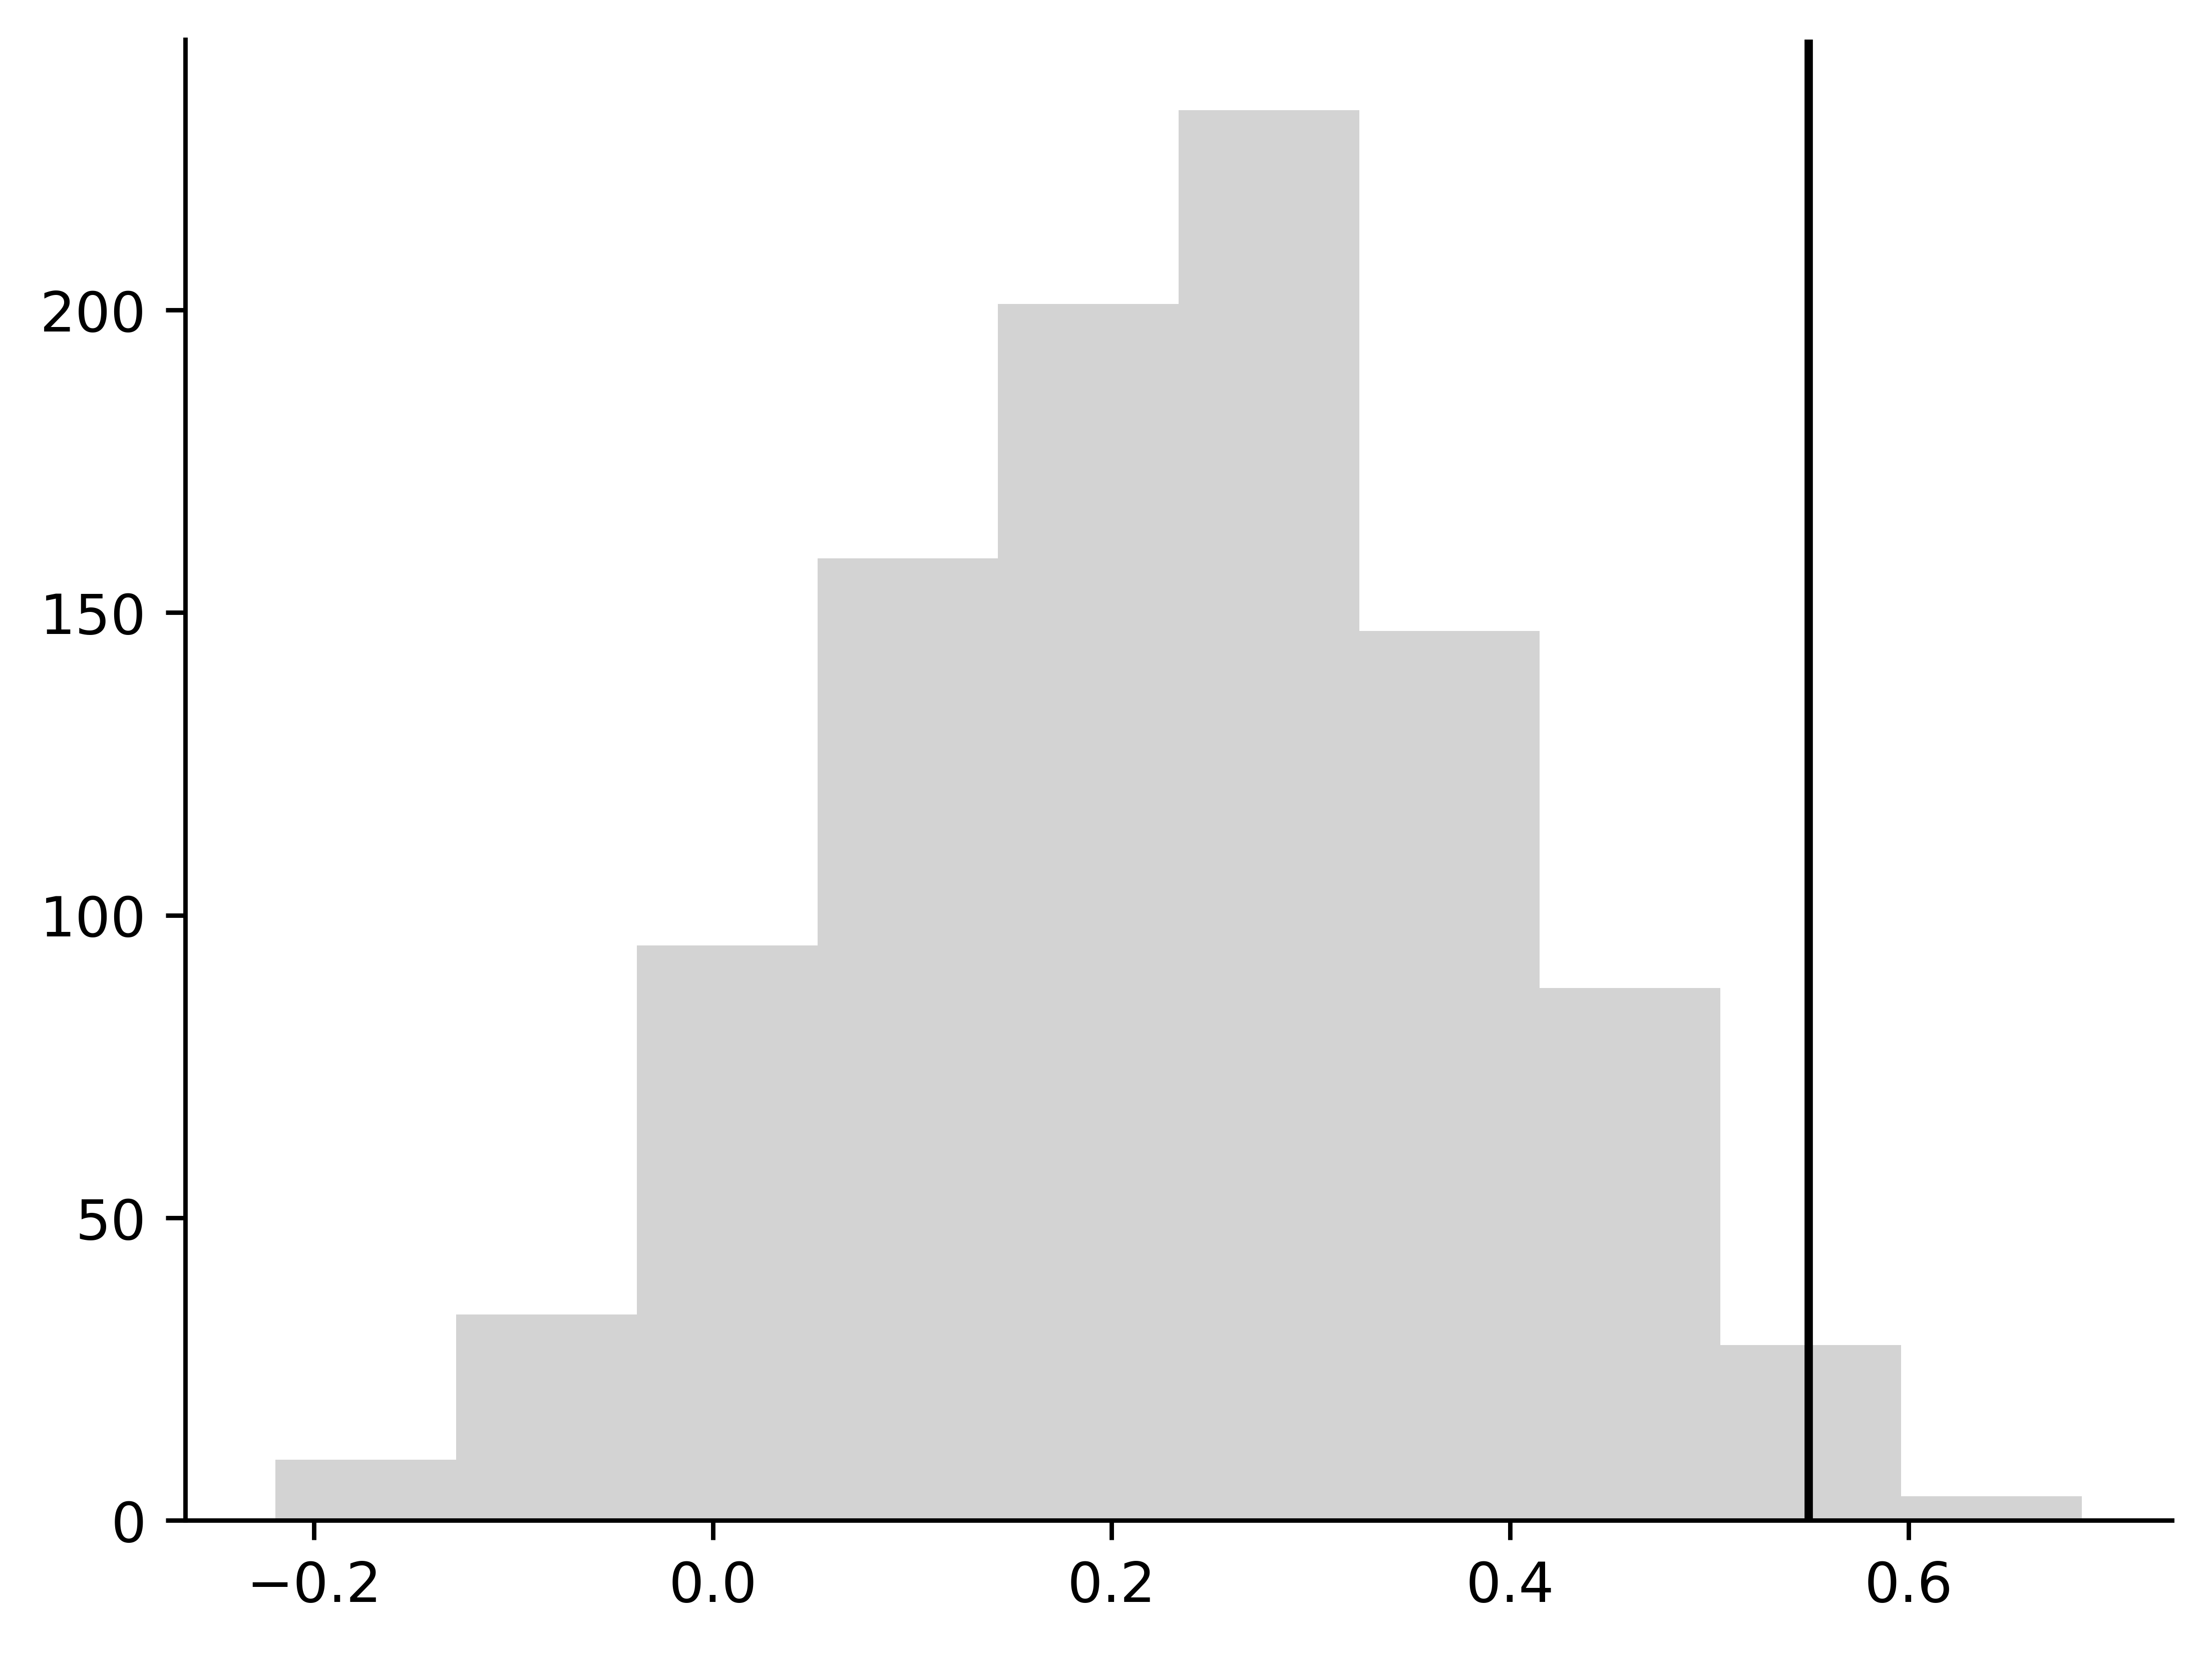

In [23]:
fig, ax = plt.subplots(dpi = 800)
ax.hist(null_dif, color='lightgray')
ax.spines[['right', 'top']].set_visible(False)
# plt.xlim([1, 9])
plt.axvline(actual_dif,color = 'black')